# Neural Network, K-means algorithms and K Nearest Neighbor

# Neural Network

接下來我要練習的是 Neural Network (NN)，要自己實作他的演算法，當然也要知道他的基本架構以及他是怎麼做 optimization的。下圖是 NN 的基本架構(一樣是借用台大林軒田老師的講記， Machine Learning Techniques L212)，除了 input/output layers 之外，中間的 hidden layers 可以自己決定層數，也可以決定各層要有幾個神經元 (Neurons)，當然一樣要小心 overfitting 的問題。

<img src="Neural Network.png" width="500" height="500" align="center"/>

在 NN 中，一樣是使用 gradient descent 來做 optimization，只是因為 NN 有數層，向上方的話有兩層 hidden layers，所以相對應的有3個不同的 W，所以在計算上比較特別，並不能直接計算得到。另外，在這裡的 NN 中，會使用 tanh 當作 transformation func.：

$$ X^{(1)} = tanh(W^{(1)T}X^{0})$$

如果要應用 gradient descent 在 NN 上，我們需要使用 Backpropagation Algorithm :


initialize all weight $w_{ij}^{l}$, for t = 0,1,..... T

* stochastic : randomly pick n $\in$ {1,2,....,N} 


* forward : compute all $x_{i}^{l}$ with $x^{(0)} = x_{n}$


* backward compute all $\delta_{j}^{l}$ subject to $x^{(0)} = x_{n}$ , 

    where $\delta_{j}^{l}$ = $\frac{\partial e_{n}}{\partial s^{(l)}_{j}}$ = $\Sigma_{k}(\delta_{k}^{(l+1)})(w_{jk}^{l+1})(tanh'(s_{j}^{l}))$

* gradient descent : $w_{ij}^{l} \leftarrow w_{ij}^{l} - \eta x_{i}^{(l-1)}\delta_{j}^{l}$ 

### return $g_{NNET}(x) = (.....tanh(\Sigma_{j}w_{jk}^{(2)}*tanh(\Sigma_{i}w_{ij}^{(l)}x_{i})))$

因為 $\delta_{j}^{l}$ 的計算要從$\delta_{j}^{L}$往回算，因此這個演算法被稱為 backpropagation。

另外要注意到， 因為 NN 不保證是 convex的，所以取 gradient 之後也不保證一定會找到 global min，因此 W 的初始也會影響 NN 計算的結果。

In [17]:
import numpy as np
from numpy.linalg import matrix_power
import numpy.linalg as la
from matplotlib import pyplot as plt
import math

X_train = np.genfromtxt("/Users/huangyuchen/Desktop/ML_NTU/hw4_nnet_train.dat.txt")
X_test = np.genfromtxt("/Users/huangyuchen/Desktop/ML_NTU/hw4_nnet_test.dat.txt")

## adding bias term
X_train = np.insert(X_train,0,1,1)
X_test = np.insert(X_test,0,1,1)


y_tr = X_train[:,-1]
Y_test = X_test[:,-1]

T = 50000

一樣先偷看一下 data。

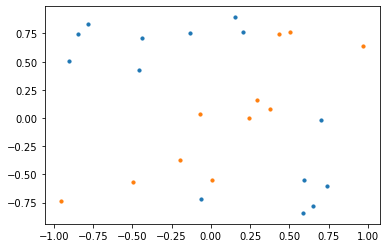

In [2]:
plt.scatter(X_train[y_tr == 1][:,1 ], X_train[y_tr == 1][:, 2], s = 10, label='1')
plt.scatter(X_train[y_tr == -1][:,1], X_train[y_tr == -1][:, 2], s = 10, label='-1')
## 重新將Ｙ的size定義好。
y_tr = np.reshape(X_train[:,-1],(-1,1))
Y_test = np.reshape(X_test[:,-1],(-1,1))

這裡計算 trasformation func.和他的微分。

In [3]:
def tanh(x):
    return np.tanh(x)
def tanhp(x):
    return 1/((np.cosh(x))**2)

In [4]:
def NNet(X_train,y_tr,n1,n2,eta):
    Fout = 0 
    Fin = 0
    m,n = X_train.shape
    ## 因為 W 的初始會影響 NN 計算的結果，所以我們重複100次實驗。
    for k in range(100):
        ## 先制定空的neurons
        S1 = np.zeros((n1,1))
        S2 = np.zeros((n2,1))
        S3 = np.zeros((n2+1,1))
        
        ## 隨機生成W1,W2,W3
        W1 = (np.random.randint(-10,10,(n-1,n1))/100)
        W2 = (np.random.randint(-10,10,(n1+1,n2))/100)
        W3 = (np.random.randint(-10,10,(n2+1,1))/100)
        ## W 隨機生成 50000次，重複實驗
        for l in range(50000):
            ## forward compute 
            ## 隨機選擇 n
            num = np.random.randint(0,m)
            S1 = X_train[num,:3].dot(W1)  
            S1 = np.resize(S1,(n1,1))
            X1 = tanh(S1)
            X1 = np.insert(X1,0,1,0) 
            S2 = X1.T.dot(W2) 
            S2 = np.resize(S2,(n2,1))
            X2 = tanh(S2)
            X2 = np.insert(X2,0,1,0)
            S3 = X2.T.dot(W3)
            X3 = tanh(S3)
            ##==================================================##
            ## backpropagation
            d3 = -2*(y_tr[num]-X3)*(tanhp(S3))
            d2 = (d3*W3[1:])*(tanhp(S2))        
            d1 = (W2[1:].dot(d2))*(tanhp(S1))
            X = np.resize(X_train[num,:3],(n2,1))   
            W1 = W1 - eta*X.dot(d1.T)        
            W2 = W2 - eta*X1.dot(d2.T)
            W3 = W3 - eta*np.resize(d3*X2,(n2+1,1))        
            ##==================================================##
        ## 計算E_out,E_in
        P_test = tanh(X_test[:,:3].dot(W1))
        P_trai = tanh(X_train[:,:3].dot(W1))
        P_test1 = np.insert(P_test,0,1,1)
        P_trai1 = np.insert(P_trai,0,1,1) 
        P_test2 = tanh(P_test1.dot(W2))
        P_trai2 = tanh(P_trai1.dot(W2))
        P_test2_ = np.insert(P_test2,0,1,1)
        P_trai2_ = np.insert(P_trai2,0,1,1) 
        P_test3 = tanh(P_test2_.dot(W3))
        P_trai3 = tanh(P_trai2_.dot(W3))
        Fin += np.mean(np.sign(P_trai3)!=y_tr)
        Fout += np.mean(np.sign(P_test3)!=Y_test)
    return Fout/100,Fin/100

In [5]:
Ein = []
Eout = []
for i in range(1,8):
    Fout,Fin = NNet(X_train,y_tr,i,3,0.01)
    Ein.append(Fin)
    Eout.append(Fout)
    
print(Ein)
print(Eout)

[0.04400000000000002, 0.004, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.05867999999999995, 0.041160000000000016, 0.036680000000000025, 0.03672000000000002, 0.03744000000000002, 0.036840000000000026, 0.03640000000000002]


我們固定層數，試著對 neurons 的數量和 Error 做分析，neurons 的數量越高，不論是E_in 和 E_out 的誤差都會變小。從 # neurons = 3開始，E_in = 0，而且 E_out 也差不多在 3.6% 附近跑，就算再增加 neurons 的數量，E_out 的表現也不會再更好了。如果要試著解決這樣的問題，增加 training set 是其中一個可能的方法。

如果這樣的 E_out 表現已經可以接受，那將 # neurons = 3 會是計算效率上最好的值。

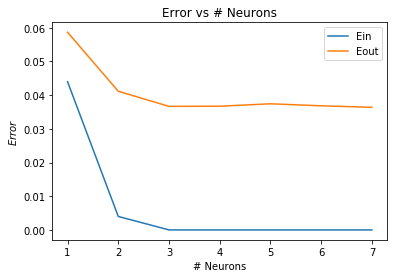

In [23]:
w_ = np.linspace(1,7,7)
fig = plt.figure()
plt.plot(w_,Ein)
plt.plot(w_,Eout)

plt.title('Error vs # Neurons')
plt.ylabel("$Error$ ")
plt.xlabel("# Neurons")
plt.legend(['Ein','Eout'])

# K-means Algorithm

K-means 的目標是將 data set 分成 K 個集合，通常會搭配 RBF Network，不過這邊我們只會實作 K-means Algorithms。

* initialize $\mu_{1},\mu_{2},\mu_{3}....\mu_{k} :$ k randomly chosen $x_{n}$

* alternating optimization of $E_{in}$ : repeatedly
    
    * optimize $S_{1},S_{2}......S_{k}:$
    
    where $S_{k}$ is the subsets of dataset.
     
    each $x_{n}$ "optimally partitioned" using its closest $\mu_{i}$
    
    * optimize $ \mu_{1},\mu_{2}......\mu_{k}:$
       
    each $\mu_{n}$ "optimally computed" as consensus within $S_{m}$ until converage
    
  
* converage : no change of $S_{1},S_{2}......S_{k}$ - guaranteed as $E_{in}$ decreases during alternating minimization.


where $E_{in}(S_{1},S_{2}......S_{k};\mu_{1},\mu_{2}......\mu_{k}) = \frac{1}{N}\Sigma_{n=1}^{N}\Sigma_{m=1}^{M} [x_{n}\in S_{m}]||x_{n} - \mu_{m}||^{2}$ 

In [9]:
X_kmean = np.genfromtxt("/Users/huangyuchen/Desktop/ML_NTU/hw4_nolabel_train.dat.txt")
n,m = X_kmean.shape

In [36]:
class Kmean:
    
    def __init__(self, k):
        ## import K
        self.k = k
        
    def optimal(self,Xtrain):
        Fs = 0
        ## initialize mu_{k}
        mu = np.random.randint(0,n,self.k)
        Xm = np.split(X_kmean[mu],self.k,axis = 0)
        Xm = np.reshape(Xm,(self.k,1,m))
        ## initailize S_{k}
        S = np.zeros((self.k,1,m)) 
        label1 = np.zeros((n,))
        ## create empty label
        
        ## 重複實驗500次
        for l in range(500):
            ## 只要還可以繼續更新，就繼續更新。
            while True:
                ## calculate |X-Xm|^2 and choose min as label
                norm = la.norm((Xtrain - Xm),axis = 2) 
                ## label 會計算各個點最靠近的 S_{k}，
                label = np.argmin(norm,axis = 0)
                for i in range(self.k):
                    ## 如果label全部都是同一個分類，或是全部都不是i這個分類，就啥事都不要做。
                    if np.sum(i==label) == 0 or np.sum(i!=label) == 0:
                        continue
                        
                    ## 將所有被label成i的點組合起來計算出新的 mu
                    else:
                        S[i] = np.sum(Xtrain[i==label],axis = 0)/np.sum(i==label)
                
                ## 如果更新後的label和前一個label一樣，那就跳出迴圈。
                if np.mean(label==label1)==1:
                    break
                ## 更新mu
                else:
                    Xm = S
                ## 更新 label   
                label1 = label
                
            ##計算 Ein
            for i in range(self.k):
                di = Xtrain[i==label]-S[i]
                Fs = Fs + (1/n)*np.sum(np.sum(di*di,axis=1))

        return Fs/500

FS = []

for i in range(1,11):
    K_m = Kmean(i)
    FS.append(K_m.optimal(X_kmean))

當我們將一組data分成越多群，他們和各自的中心點距離的合，應該要變小，就如下圖所示。

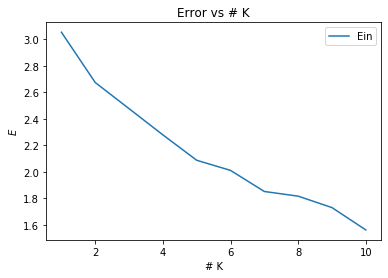

In [37]:
w_ = np.linspace(1,10,10)
fig = plt.figure()
plt.plot(w_,FS)

plt.title('Error vs # K')
plt.ylabel("$E$ ")
plt.xlabel("# K")
plt.legend(['Ein'])

# K Nearest Neighbor

### $g_{uniform}(x)$ = $sign(\Sigma_{m=1}^{N}y_{m} exp(-\gamma |x-x_{m}|^{2})$ )


* $exp(-\gamma |x-x_{m}|^{2})$) : max when x closest to $x_{m}$ - max one dominates.


* we take $y_{m}$ of max exp(...) here.


* meaning : 
    
  $g_{nbor}(x) = y_{m}$ s.t x closest to $x_{m}$
  

In [65]:
X_nbor_train = np.genfromtxt("/Users/huangyuchen/Desktop/ML_NTU/hw4_nbor_train.dat.txt")
X_nbor_test = np.genfromtxt("/Users/huangyuchen/Desktop/ML_NTU/hw4_nbor_test.dat.txt")

Y = X_nbor_train[:,-1]
Y = np.reshape(Y,(-1,1))
Y_test = X_nbor_test[:,-1]
Y_test = np.reshape(Y_test,(-1,1))

In [163]:
class K_NN:
    def __init__(self, k):
        ## 決定有幾個 K nearest neighbor
        self.k = k
        
    def KNN(self, X_tr,X_te,Y,Y_test):
        #==========================================#
        ## 計算 |x-xm|^2，如果是在計算 X_test的話，用X_train 來當作 xm
        dX = np.sum(X_tr*X_tr,axis = 1)
        dXX = np.sum(X_te*X_te,axis =1)
        disx = np.reshape(dX,(1,-1))
        disxx = np.reshape(dXX,(-1,1))
        dist = (disxx + disx) - 2*X_te.dot(X_tr.T)
        #==========================================#
        ## 選擇最靠近的 K 個點
        idx = np.argsort(dist,axis = 1)[:,:self.k]
        ## 將最靠近 K 個點的 ym 相加
        result = np.sum(Y[idx],axis = 1)
        ## 因為偶數點有一定機率會出現相加後 = 0，所以手動把它變成 -1。
        result[result == 0] = -1
        y = np.sign(result)
        return np.mean(y!=Y_test)

Ein = []
Eout = []

for i in range(1,10):
    Neibor = K_NN(i)
    Ein.append(Neibor.KNN(X_nbor_train[:,:-1],X_nbor_train[:,:-1],Y,Y)) 
    Eout.append(Neibor.KNN(X_nbor_train[:,:-1],X_nbor_test[:,:-1],Y,Y_test))

如果 K = 1，E_in理所當然會 = 0，因為最靠近自己的點就是自己。但是隨著K越大 Ein反而有越差的趨勢，所以我猜可能這樣的演算法還是太簡陋了，還是要把權重考慮進去，才可以得到比較好的結果。

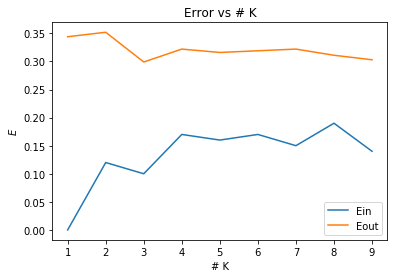

In [164]:
w_ = np.linspace(1,9,9)
fig = plt.figure()
plt.plot(w_,Ein)
plt.plot(w_,Eout)

plt.title('Error vs # K')
plt.ylabel("$E$ ")
plt.xlabel("# K")
plt.legend(['Ein','Eout'])

下面把權重都考慮進去，為了方便計算令K = total # data。從圖表可以看出來，隨著$\gamma$ 越大，E_in就會越小，這是因為 $\gamma$ 越大越會強調 $x = x_{m}$這個點的權重，當然預測出來的結果就會越準。

至於E_out的趨勢大致上和E_in一樣，但是最小值出現在$\gamma$ = 0.01的地方，這代表$\gamma$ 太大可能造成了 overfitting。

In [317]:
class K_NN＿weight:
    def __init__(self,ga):
        ## 決定gamma

        self.ga = ga
        
    def KNN(self,X_tr,X_te,Y,Y_test):
        #==========================================#
        ## 計算 |x-xm|^2，如果是在計算 X_test的話，用X_train 來當作 xm
        dX = np.sum(X_tr*X_tr,axis = 1)
        dXX = np.sum(X_te*X_te,axis =1)
        disx = np.reshape(dX,(1,-1))
        disxx = np.reshape(dXX,(-1,1))
        dist = (disxx + disx) - 2*X_te.dot(X_tr.T)
        #==========================================#
        ## 計算權重
        d = np.exp((-self.ga)*dist)
        
        ## ym乘上權重之後的結果相加
        result = np.reshape(np.sum(d*Y.T,axis = 1),(-1,1))
        y = np.sign(result)
        
        
        return np.mean(y!=Y_test)


Ein = []
Eout = []
gamma = [0.001,0.01,0.1,1,10,100]
for i in gamma:
    Neibor = K_NN_weight(i)
    Ein.append(Neibor.KNN(X_nbor_train[:,:-1],X_nbor_train[:,:-1],Y,Y)) 
    Eout.append(Neibor.KNN(X_nbor_train[:,:-1],X_nbor_test[:,:-1],Y,Y_test))

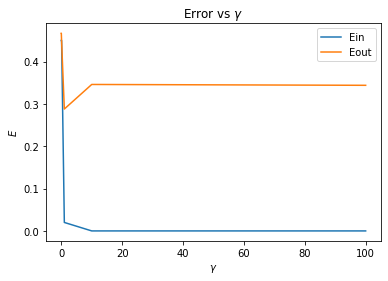

In [320]:
fig = plt.figure()
plt.plot(gamma,Ein)
plt.plot(gamma,Eout)

plt.title('Error vs $\gamma$')
plt.ylabel("$E$ ")
plt.xlabel("$\gamma$")
plt.legend(['Ein','Eout'])